In [1]:
import time

import numpy as np
import pandas as pd
import os
import cv2
import os
import re
import torch
import torchvision
import xml.etree.ElementTree as ET

from IPython.core.display_functions import clear_output
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt, patches

In [3]:
root_dir = "C:/Users/allex/Desktop/git_repos/roadsign-detection"

In [4]:
for dirpath, dirnames, filenames in os.walk(
        "C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection"):
    for idx, filename in enumerate(filenames):
        if idx < 8:
            print(os.path.join(dirpath, filename))

C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road0.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road1.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road10.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road100.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road101.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road102.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road103.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road104.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\images\road0.png
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\images\road1.png

In [5]:
def parse_xml_file(xml_file):
    tree = ET.parse(source=xml_file)
    root = tree.getroot()
    data_list = []

    for obj in root.findall('object'):
        data = {
            "image_id": root.find("filename").text,
            "xmin": float(obj.find(".//xmin").text),
            "ymin": float(obj.find(".//ymin").text),
            "xmax": float(obj.find(".//xmax").text),
            "ymax": float(obj.find(".//ymax").text),
            "label": obj.find(".//name").text,
        }

        data_list.append(data)

    return data_list


def parse_xml_files(dir_path):
    all_data_list = []

    xml_files = [file for file in os.listdir(dir_path) if file.endswith(".xml")]
    # print(xml_files[:10])
    for xml_file in xml_files:
        xml_path = os.path.join(dir_path, xml_file)
        data = parse_xml_file(xml_path)
        all_data_list.extend(data)

    return all_data_list


data_list = parse_xml_files(os.path.join(root_dir, "data/road-sign-detection/annotations"))
print(data_list[:8])
df = pd.DataFrame(data_list)

[{'image_id': 'road0.png', 'xmin': 98.0, 'ymin': 62.0, 'xmax': 208.0, 'ymax': 232.0, 'label': 'trafficlight'}, {'image_id': 'road1.png', 'xmin': 154.0, 'ymin': 63.0, 'xmax': 258.0, 'ymax': 281.0, 'label': 'trafficlight'}, {'image_id': 'road10.png', 'xmin': 106.0, 'ymin': 3.0, 'xmax': 244.0, 'ymax': 263.0, 'label': 'trafficlight'}, {'image_id': 'road100.png', 'xmin': 35.0, 'ymin': 5.0, 'xmax': 363.0, 'ymax': 326.0, 'label': 'speedlimit'}, {'image_id': 'road101.png', 'xmin': 195.0, 'ymin': 7.0, 'xmax': 392.0, 'ymax': 194.0, 'label': 'speedlimit'}, {'image_id': 'road102.png', 'xmin': 37.0, 'ymin': 38.0, 'xmax': 243.0, 'ymax': 245.0, 'label': 'speedlimit'}, {'image_id': 'road103.png', 'xmin': 89.0, 'ymin': 25.0, 'xmax': 297.0, 'ymax': 272.0, 'label': 'speedlimit'}, {'image_id': 'road104.png', 'xmin': 48.0, 'ymin': 14.0, 'xmax': 344.0, 'ymax': 345.0, 'label': 'speedlimit'}]


In [26]:
df

,image_id,xmin,ymin,xmax,ymax,label
0,road0.png,98.0,62.0,208.0,232.0,trafficlight
1,road1.png,154.0,63.0,258.0,281.0,trafficlight
2,road10.png,106.0,3.0,244.0,263.0,trafficlight
3,road100.png,35.0,5.0,363.0,326.0,speedlimit
4,road101.png,195.0,7.0,392.0,194.0,speedlimit
...,...,...,...,...,...,...
1239,road95.png,90.0,101.0,268.0,257.0,stop
1240,road96.png,209.0,58.0,326.0,179.0,stop
1241,road97.png,42.0,66.0,130.0,154.0,stop
1242,road98.png,138.0,17.0,376.0,245.0,stop


In [27]:
df.size

7464

In [6]:
img_ids = df["image_id"].unique()

split = int(len(img_ids) * 0.15)

valid_ids = img_ids[-split:]
train_ids = img_ids[:-split]

valid_df = df[df["image_id"].isin(valid_ids)]
train_df = df[df["image_id"].isin(train_ids)]

# train_df["image_id"]
valid_df

,image_id,xmin,ymin,xmax,ymax,label
1039,road770.png,138.0,164.0,171.0,194.0,speedlimit
1040,road771.png,139.0,155.0,176.0,194.0,speedlimit
1041,road772.png,137.0,185.0,154.0,204.0,speedlimit
1042,road773.png,184.0,188.0,204.0,208.0,speedlimit
1043,road774.png,186.0,162.0,207.0,186.0,speedlimit
...,...,...,...,...,...,...
1239,road95.png,90.0,101.0,268.0,257.0,stop
1240,road96.png,209.0,58.0,326.0,179.0,stop
1241,road97.png,42.0,66.0,130.0,154.0,stop
1242,road98.png,138.0,17.0,376.0,245.0,stop


In [30]:
df[df["image_id"] == "road706.png"].get("label")

926    speedlimit
927    speedlimit
Name: label, dtype: object

In [7]:
class_to_idx = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

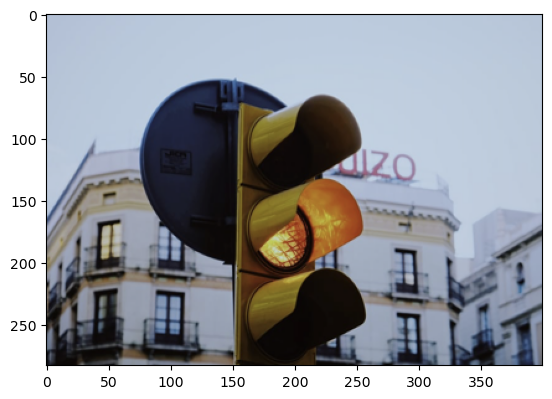

In [32]:
image_ids = df["image_id"].unique()
img_id = image_ids[1]
image = cv2.imread(f"./data/road-sign-detection/images/{img_id}", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [8]:
class RoadSignDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None, train=True):
        super().__init__()

        self.df = dataframe
        self.image_ids = dataframe["image_id"].unique()
        self.image_dir = image_dir
        self.transforms = transforms
        self.train = train

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:
            image = self.transforms(image)
        if not self.train:
            return image, image_id
        records = self.df[self.df["image_id"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values.astype(float)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = []
        for label in records.get("label"):
            labels.append(class_to_idx[label])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': area,
            'iscrowd': iscrowd
        }

        return image, target, image_id

In [9]:
class Averager:  ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
train_dir = valid_dir = "./data/road-sign-detection/images"

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = RoadSignDataset(train_df, train_dir, transform, True)
valid_dataset = RoadSignDataset(valid_df, valid_dir, transform, True)

train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [38]:
valid_dataset.__getitem__(5)

(tensor([[[0.6196, 0.6275, 0.6314,  ..., 0.6196, 0.6196, 0.6196],
          [0.6275, 0.6314, 0.6314,  ..., 0.6157, 0.6196, 0.6196],
          [0.6314, 0.6314, 0.6314,  ..., 0.6157, 0.6275, 0.6157],
          ...,
          [0.2235, 0.2196, 0.2314,  ..., 0.1529, 0.1490, 0.1490],
          [0.2000, 0.2039, 0.2118,  ..., 0.1529, 0.1529, 0.1686],
          [0.2078, 0.2039, 0.2039,  ..., 0.1451, 0.1412, 0.1529]],
 
         [[0.8275, 0.8235, 0.8275,  ..., 0.8235, 0.8275, 0.8275],
          [0.8353, 0.8275, 0.8275,  ..., 0.8196, 0.8235, 0.8235],
          [0.8314, 0.8275, 0.8275,  ..., 0.8235, 0.8275, 0.8196],
          ...,
          [0.3765, 0.3686, 0.3804,  ..., 0.2745, 0.2627, 0.2667],
          [0.3647, 0.3647, 0.3686,  ..., 0.2784, 0.2745, 0.2863],
          [0.3882, 0.3765, 0.3647,  ..., 0.2784, 0.2706, 0.2863]],
 
         [[0.8510, 0.8627, 0.8667,  ..., 0.8824, 0.8824, 0.8824],
          [0.8588, 0.8667, 0.8667,  ..., 0.8784, 0.8824, 0.8824],
          [0.8706, 0.8745, 0.8667,  ...,

<class 'tuple'>
tensor([2])


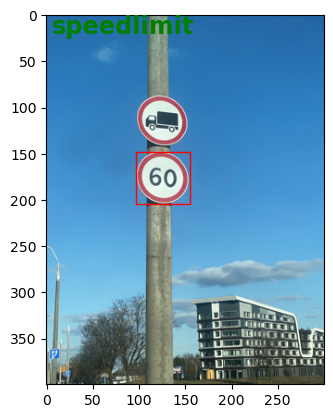

In [19]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None


see_examples = 1
for imgs, targets, image_ids in train_data_loader:
    for idx in range(len(targets[4]["labels"])):
        clear_output(wait=True)
        print(type(imgs))
        print(targets[4]["labels"])
        coords = targets[4]['boxes'].numpy().astype(np.int32)[idx]
        sample = imgs[4].permute(1, 2, 0).numpy()

        plt.imshow(sample)

        x1, y1, x2, y2 = coords
        rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(5, 20, get_key_from_value(class_to_idx, targets[4]["labels"][idx]), fontsize='xx-large', color='g',
                 fontweight='bold')
        plt.show()

        see_examples -= 1
        time.sleep(1)

    if see_examples < 0:
        break

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [56]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

In [57]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [58]:
num_classes = 4

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [59]:
print(train_data_loader.__len__())

94


In [60]:
import time

model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 1

loss_hist = Averager()

itr = 1
for epoch in range(num_epochs):
    start = time.time()
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            end = time.time()
            print(f"Iteration #{itr} loss: {loss_value:.3f} time:{end - start:.1f}s")
            start = time.time()

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #10 loss: 0.233 time:62.6s
Iteration #20 loss: 0.076 time:66.4s
Iteration #30 loss: 0.077 time:49.9s
Iteration #40 loss: 0.094 time:30.4s
Iteration #50 loss: 0.166 time:37.9s
Iteration #60 loss: 0.139 time:52.1s
Iteration #70 loss: 0.092 time:54.3s
Iteration #80 loss: 0.076 time:58.1s
Iteration #90 loss: 0.029 time:54.8s
Epoch #0 loss: 0.17954588970763885


In [58]:
batch = next(iter(valid_data_loader))

images, targets, image_ids = batch

targets[3]["labels"].size(dim=0)

len(targets)
batch
targets[0]["labels"]

tensor([2])

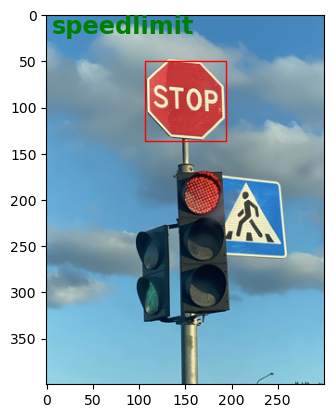

In [63]:
detection_threshold = 0.45
model.eval()
see_examples = 20
acc = 0
# total = 0
for idx, (images, targets, image_ids) in enumerate(valid_data_loader):
    if idx != 14:
        continue
    # for i in range(len(targets)):
    #     total += targets[i]['labels'].size(dim = 0)

    images = [image.to(device) for image in images]
    outputs = model(images)
    images = [image.cpu() for image in images]

    # plt.imshow(images[0])
    # plt.show()

    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()

        for idx, (box, scor, label) in enumerate(zip(boxes, scores, labels)):
            if scor >= detection_threshold:
                print(label)
                clear_output(wait=True)
                sample = image.permute(1, 2, 0).numpy()

                plt.imshow(sample)
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r',
                                         facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(5, 20, get_key_from_value(class_to_idx, label), fontsize='xx-large', color='g',
                         fontweight='bold')
                plt.show()

                see_examples -= 1
                time.sleep(1)

        if see_examples < 0:
            break


In [61]:
torch.save(model.state_dict(), f"models/fastercnn_resnet50_{num_epochs}epochs_roadsigns")

# Load Model

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn()

num_classes = 4

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("models/fastercnn_resnet50_1epochs_roadsigns"))

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Compute accuracy of correct labels

In [15]:
def calculate_iou(boxA, boxB):
    # boxA and boxB are tuples/lists representing bounding boxes in the format (x1, y1, x2, y2)
    # where (x1, y1) are the coordinates of the top-left corner
    # and (x2, y2) are the coordinates of the bottom-right corner

    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of intersection rectangle
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of the individual bounding boxes
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate the area of union
    union_area = boxA_area + boxB_area - intersection_area

    # Calculate IOU
    iou = intersection_area / union_area

    return iou


In [29]:
detection_threshold = 0.5
model.eval()
correct_boxes90 = 0
correct_boxes75 = 0
correct_boxes50 = 0

correct_boxes90_and_labels = 0
correct_boxes75_and_labels = 0
correct_boxes50_and_labels = 0

total_boxes = 0
show_images = False


def show_detected_images():
    global sample, x1, y1, x2, y2, rect
    if show_images:
        clear_output(wait=True)
        sample = image.permute(1, 2, 0).numpy()
        x1, y1, x2, y2 = predicted_box.cpu().detach().numpy().astype(np.int32)
        plt.imshow(sample)
        rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
        plt.text(5, 20, get_key_from_value(class_to_idx, predicted_label), fontsize='xx-large', color='g',
                 fontweight='bold')
        plt.gca().add_patch(rect)
        plt.show()

        time.sleep(1)


for images, targets, image_ids in valid_data_loader:

    images = [image.to(device) for image in images]
    outputs = model(images)
    images = [image.cpu() for image in images]

    for idx, image in enumerate(images):
        gt_labels = targets[idx]["labels"]
        gt_boxes = targets[idx]["boxes"]
        predicted_labels = outputs[idx]["labels"][outputs[idx]["scores"] > detection_threshold]
        predicted_scores = outputs[idx]["scores"][outputs[idx]["scores"] > detection_threshold]
        predicted_boxes = outputs[idx]["boxes"][outputs[idx]["scores"] > detection_threshold]

        for gt_box, gt_label in zip(gt_boxes, gt_labels):

            for predicted_box, predicted_label in zip(predicted_boxes, predicted_labels):
                if calculate_iou(gt_box, predicted_box) > 0.90 :
                    correct_boxes90 += 1
                    correct_boxes75 += 1
                    correct_boxes50 += 1
                    show_detected_images()
                    if gt_label == predicted_label:
                        correct_boxes90_and_labels += 1
                        correct_boxes75_and_labels += 1
                        correct_boxes50_and_labels += 1
                    break
                    
                elif calculate_iou(gt_box, predicted_box) > 0.75:
                    correct_boxes75 += 1
                    correct_boxes50 += 1
                    show_detected_images()
                    if gt_label == predicted_label:
                        correct_boxes75_and_labels += 1
                        correct_boxes50_and_labels += 1
                    break
                    
                elif calculate_iou(gt_box, predicted_box) > 0.5:
                    correct_boxes50 += 1
                    show_detected_images()
                    if gt_label == predicted_label:
                        correct_boxes50_and_labels += 1
                    break

            total_boxes += 1
print(f"Accuracy for 50% iou: {correct_boxes50 / total_boxes:.2f}")
print(f"Accuracy for 75% iou: {correct_boxes75 / total_boxes:.2f}")
print(f"Accuracy for 90% iou: {correct_boxes90 / total_boxes:.2f}")

print(f"Accuracy for 50% iou and correct label: {correct_boxes50_and_labels / total_boxes:.2f}")
print(f"Accuracy for 75% iou and correct label: {correct_boxes75_and_labels / total_boxes:.2f}")
print(f"Accuracy for 90% iou and correct label: {correct_boxes90_and_labels / total_boxes:.2f}")


Accuracy for 50% iou: 0.78
Accuracy for 75% iou: 0.75
Accuracy for 90% iou: 0.48
Accuracy for 50% iou and correct label: 0.62
Accuracy for 75% iou and correct label: 0.60
Accuracy for 90% iou and correct label: 0.38
